# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4202496/11490434 [=========>....................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:23 - loss: 0.6926

  29/1875 [..............................] - ETA: 3s - loss: 0.5458   

  60/1875 [..............................] - ETA: 3s - loss: 0.4608

  92/1875 [>.............................] - ETA: 2s - loss: 0.4167

 123/1875 [>.............................] - ETA: 2s - loss: 0.3899

 154/1875 [=>............................] - ETA: 2s - loss: 0.3707

 187/1875 [=>............................] - ETA: 2s - loss: 0.3548

 216/1875 [==>...........................] - ETA: 2s - loss: 0.3433

 254/1875 [===>..........................] - ETA: 2s - loss: 0.3308

 291/1875 [===>..........................] - ETA: 2s - loss: 0.3205

 322/1875 [====>.........................] - ETA: 2s - loss: 0.3130

 356/1875 [====>.........................] - ETA: 2s - loss: 0.3057

 391/1875 [=====>........................] - ETA: 2s - loss: 0.2989

 428/1875 [=====>........................] - ETA: 2s - loss: 0.2925

 466/1875 [======>.......................] - ETA: 2s - loss: 0.2865

 496/1875 [======>.......................] - ETA: 2s - loss: 0.2822

 528/1875 [=======>......................] - ETA: 2s - loss: 0.2779

 560/1875 [=======>......................] - ETA: 2s - loss: 0.2739

 592/1875 [========>.....................] - ETA: 1s - loss: 0.2701

 624/1875 [========>.....................] - ETA: 1s - loss: 0.2666

 655/1875 [=========>....................] - ETA: 1s - loss: 0.2634

 687/1875 [=========>....................] - ETA: 1s - loss: 0.2603

 718/1875 [==========>...................] - ETA: 1s - loss: 0.2574

 750/1875 [===========>..................] - ETA: 1s - loss: 0.2546

 780/1875 [===========>..................] - ETA: 1s - loss: 0.2521

 811/1875 [===========>..................] - ETA: 1s - loss: 0.2496

 844/1875 [============>.................] - ETA: 1s - loss: 0.2471

 877/1875 [=============>................] - ETA: 1s - loss: 0.2447

 912/1875 [=============>................] - ETA: 1s - loss: 0.2423

 946/1875 [==============>...............] - ETA: 1s - loss: 0.2401

 978/1875 [==============>...............] - ETA: 1s - loss: 0.2380

1012/1875 [===============>..............] - ETA: 1s - loss: 0.2360

1043/1875 [===============>..............] - ETA: 1s - loss: 0.2341

1075/1875 [================>.............] - ETA: 1s - loss: 0.2323

1106/1875 [================>.............] - ETA: 1s - loss: 0.2307

1138/1875 [=================>............] - ETA: 1s - loss: 0.2290

1168/1875 [=================>............] - ETA: 1s - loss: 0.2274

1200/1875 [==================>...........] - ETA: 1s - loss: 0.2259

1235/1875 [==================>...........] - ETA: 1s - loss: 0.2242

1267/1875 [===================>..........] - ETA: 0s - loss: 0.2227

1299/1875 [===================>..........] - ETA: 0s - loss: 0.2213

1334/1875 [====================>.........] - ETA: 0s - loss: 0.2198

1368/1875 [====================>.........] - ETA: 0s - loss: 0.2183

1392/1875 [=====================>........] - ETA: 0s - loss: 0.2173

1421/1875 [=====================>........] - ETA: 0s - loss: 0.2162

1452/1875 [======================>.......] - ETA: 0s - loss: 0.2150

1486/1875 [======================>.......] - ETA: 0s - loss: 0.2137

1519/1875 [=======================>......] - ETA: 0s - loss: 0.2125

1553/1875 [=======================>......] - ETA: 0s - loss: 0.2113

1587/1875 [========================>.....] - ETA: 0s - loss: 0.2101

1621/1875 [========================>.....] - ETA: 0s - loss: 0.2089

1654/1875 [=========================>....] - ETA: 0s - loss: 0.2078

1686/1875 [=========================>....] - ETA: 0s - loss: 0.2068

1719/1875 [==========================>...] - ETA: 0s - loss: 0.2058

1749/1875 [==========================>...] - ETA: 0s - loss: 0.2048

1780/1875 [===========================>..] - ETA: 0s - loss: 0.2039

1810/1875 [===========================>..] - ETA: 0s - loss: 0.2030

1843/1875 [============================>.] - ETA: 0s - loss: 0.2021

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2011


Epoch 2/5
   1/1875 [..............................] - ETA: 5s - loss: 0.0992

  35/1875 [..............................] - ETA: 2s - loss: 0.1092

  68/1875 [>.............................] - ETA: 2s - loss: 0.1091

 102/1875 [>.............................] - ETA: 2s - loss: 0.1091

 136/1875 [=>............................] - ETA: 2s - loss: 0.1091

 167/1875 [=>............................] - ETA: 2s - loss: 0.1091

 197/1875 [==>...........................] - ETA: 2s - loss: 0.1090

 224/1875 [==>...........................] - ETA: 2s - loss: 0.1089

 255/1875 [===>..........................] - ETA: 2s - loss: 0.1088

 289/1875 [===>..........................] - ETA: 2s - loss: 0.1087

 323/1875 [====>.........................] - ETA: 2s - loss: 0.1086

 352/1875 [====>.........................] - ETA: 2s - loss: 0.1085

 383/1875 [=====>........................] - ETA: 2s - loss: 0.1084

 416/1875 [=====>........................] - ETA: 2s - loss: 0.1083

 446/1875 [======>.......................] - ETA: 2s - loss: 0.1082

 478/1875 [======>.......................] - ETA: 2s - loss: 0.1081

 510/1875 [=======>......................] - ETA: 2s - loss: 0.1081

 543/1875 [=======>......................] - ETA: 2s - loss: 0.1080

 576/1875 [========>.....................] - ETA: 2s - loss: 0.1079

 609/1875 [========>.....................] - ETA: 2s - loss: 0.1078

 636/1875 [=========>....................] - ETA: 1s - loss: 0.1078

 666/1875 [=========>....................] - ETA: 1s - loss: 0.1077

 698/1875 [==========>...................] - ETA: 1s - loss: 0.1076

 730/1875 [==========>...................] - ETA: 1s - loss: 0.1075

 762/1875 [===========>..................] - ETA: 1s - loss: 0.1075

 793/1875 [===========>..................] - ETA: 1s - loss: 0.1074

 823/1875 [============>.................] - ETA: 1s - loss: 0.1073

 850/1875 [============>.................] - ETA: 1s - loss: 0.1073

 883/1875 [=============>................] - ETA: 1s - loss: 0.1072

 915/1875 [=============>................] - ETA: 1s - loss: 0.1071

 944/1875 [==============>...............] - ETA: 1s - loss: 0.1071

 974/1875 [==============>...............] - ETA: 1s - loss: 0.1070

1004/1875 [===============>..............] - ETA: 1s - loss: 0.1070

1036/1875 [===============>..............] - ETA: 1s - loss: 0.1069

1068/1875 [================>.............] - ETA: 1s - loss: 0.1068

1104/1875 [================>.............] - ETA: 1s - loss: 0.1068

1140/1875 [=================>............] - ETA: 1s - loss: 0.1067

1170/1875 [=================>............] - ETA: 1s - loss: 0.1067

1198/1875 [==================>...........] - ETA: 1s - loss: 0.1066

1232/1875 [==================>...........] - ETA: 1s - loss: 0.1065

1267/1875 [===================>..........] - ETA: 0s - loss: 0.1065

1297/1875 [===================>..........] - ETA: 0s - loss: 0.1064

1332/1875 [====================>.........] - ETA: 0s - loss: 0.1064

1364/1875 [====================>.........] - ETA: 0s - loss: 0.1063

1397/1875 [=====================>........] - ETA: 0s - loss: 0.1063

1428/1875 [=====================>........] - ETA: 0s - loss: 0.1062

1456/1875 [======================>.......] - ETA: 0s - loss: 0.1062

1488/1875 [======================>.......] - ETA: 0s - loss: 0.1061

1516/1875 [=======================>......] - ETA: 0s - loss: 0.1061

1546/1875 [=======================>......] - ETA: 0s - loss: 0.1060

1580/1875 [========================>.....] - ETA: 0s - loss: 0.1060

1611/1875 [========================>.....] - ETA: 0s - loss: 0.1059

1642/1875 [=========================>....] - ETA: 0s - loss: 0.1059

1673/1875 [=========================>....] - ETA: 0s - loss: 0.1058

1703/1875 [==========================>...] - ETA: 0s - loss: 0.1058

1735/1875 [==========================>...] - ETA: 0s - loss: 0.1057

1767/1875 [===========================>..] - ETA: 0s - loss: 0.1057

1797/1875 [===========================>..] - ETA: 0s - loss: 0.1056

1831/1875 [============================>.] - ETA: 0s - loss: 0.1056

1863/1875 [============================>.] - ETA: 0s - loss: 0.1055

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1055


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1045

  32/1875 [..............................] - ETA: 2s - loss: 0.1015

  63/1875 [>.............................] - ETA: 2s - loss: 0.1008

  95/1875 [>.............................] - ETA: 2s - loss: 0.1005

 126/1875 [=>............................] - ETA: 2s - loss: 0.1004

 157/1875 [=>............................] - ETA: 2s - loss: 0.1002

 190/1875 [==>...........................] - ETA: 2s - loss: 0.1001

 226/1875 [==>...........................] - ETA: 2s - loss: 0.0999

 264/1875 [===>..........................] - ETA: 2s - loss: 0.0998

 297/1875 [===>..........................] - ETA: 2s - loss: 0.0997

 328/1875 [====>.........................] - ETA: 2s - loss: 0.0996

 361/1875 [====>.........................] - ETA: 2s - loss: 0.0995

 388/1875 [=====>........................] - ETA: 2s - loss: 0.0995

 417/1875 [=====>........................] - ETA: 2s - loss: 0.0994

 445/1875 [======>.......................] - ETA: 2s - loss: 0.0993

 471/1875 [======>.......................] - ETA: 2s - loss: 0.0993

 495/1875 [======>.......................] - ETA: 2s - loss: 0.0992

 517/1875 [=======>......................] - ETA: 2s - loss: 0.0992

 541/1875 [=======>......................] - ETA: 2s - loss: 0.0991

 565/1875 [========>.....................] - ETA: 2s - loss: 0.0991

 589/1875 [========>.....................] - ETA: 2s - loss: 0.0991

 615/1875 [========>.....................] - ETA: 2s - loss: 0.0990

 636/1875 [=========>....................] - ETA: 2s - loss: 0.0990

 658/1875 [=========>....................] - ETA: 2s - loss: 0.0990

 689/1875 [==========>...................] - ETA: 2s - loss: 0.0989

 720/1875 [==========>...................] - ETA: 2s - loss: 0.0989

 748/1875 [==========>...................] - ETA: 1s - loss: 0.0989

 778/1875 [===========>..................] - ETA: 1s - loss: 0.0988

 813/1875 [============>.................] - ETA: 1s - loss: 0.0988

 841/1875 [============>.................] - ETA: 1s - loss: 0.0988

 873/1875 [============>.................] - ETA: 1s - loss: 0.0987

 906/1875 [=============>................] - ETA: 1s - loss: 0.0987

 933/1875 [=============>................] - ETA: 1s - loss: 0.0987

 962/1875 [==============>...............] - ETA: 1s - loss: 0.0987

 990/1875 [==============>...............] - ETA: 1s - loss: 0.0986

1021/1875 [===============>..............] - ETA: 1s - loss: 0.0986

1052/1875 [===============>..............] - ETA: 1s - loss: 0.0986

1083/1875 [================>.............] - ETA: 1s - loss: 0.0986

1115/1875 [================>.............] - ETA: 1s - loss: 0.0985

1147/1875 [=================>............] - ETA: 1s - loss: 0.0985

1179/1875 [=================>............] - ETA: 1s - loss: 0.0985

1212/1875 [==================>...........] - ETA: 1s - loss: 0.0985

1244/1875 [==================>...........] - ETA: 1s - loss: 0.0985

1276/1875 [===================>..........] - ETA: 1s - loss: 0.0984

1307/1875 [===================>..........] - ETA: 0s - loss: 0.0984

1339/1875 [====================>.........] - ETA: 0s - loss: 0.0984

1372/1875 [====================>.........] - ETA: 0s - loss: 0.0984

1405/1875 [=====================>........] - ETA: 0s - loss: 0.0984

1437/1875 [=====================>........] - ETA: 0s - loss: 0.0983

1471/1875 [======================>.......] - ETA: 0s - loss: 0.0983

1504/1875 [=======================>......] - ETA: 0s - loss: 0.0983

1538/1875 [=======================>......] - ETA: 0s - loss: 0.0983

1575/1875 [========================>.....] - ETA: 0s - loss: 0.0983

1610/1875 [========================>.....] - ETA: 0s - loss: 0.0982

1643/1875 [=========================>....] - ETA: 0s - loss: 0.0982

1674/1875 [=========================>....] - ETA: 0s - loss: 0.0982

1703/1875 [==========================>...] - ETA: 0s - loss: 0.0982

1730/1875 [==========================>...] - ETA: 0s - loss: 0.0982

1752/1875 [===========================>..] - ETA: 0s - loss: 0.0982

1778/1875 [===========================>..] - ETA: 0s - loss: 0.0982

1807/1875 [===========================>..] - ETA: 0s - loss: 0.0981

1840/1875 [============================>.] - ETA: 0s - loss: 0.0981

1870/1875 [============================>.] - ETA: 0s - loss: 0.0981

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0981


Epoch 4/5
   1/1875 [..............................] - ETA: 2s - loss: 0.0988

  34/1875 [..............................] - ETA: 2s - loss: 0.0970

  69/1875 [>.............................] - ETA: 2s - loss: 0.0966

 102/1875 [>.............................] - ETA: 2s - loss: 0.0965

 134/1875 [=>............................] - ETA: 2s - loss: 0.0964

 166/1875 [=>............................] - ETA: 2s - loss: 0.0964

 198/1875 [==>...........................] - ETA: 2s - loss: 0.0963

 230/1875 [==>...........................] - ETA: 2s - loss: 0.0964

 262/1875 [===>..........................] - ETA: 2s - loss: 0.0964

 295/1875 [===>..........................] - ETA: 2s - loss: 0.0963

 326/1875 [====>.........................] - ETA: 2s - loss: 0.0963

 358/1875 [====>.........................] - ETA: 2s - loss: 0.0963

 390/1875 [=====>........................] - ETA: 2s - loss: 0.0963

 423/1875 [=====>........................] - ETA: 2s - loss: 0.0963

 455/1875 [======>.......................] - ETA: 2s - loss: 0.0962

 486/1875 [======>.......................] - ETA: 2s - loss: 0.0962

 518/1875 [=======>......................] - ETA: 2s - loss: 0.0962

 548/1875 [=======>......................] - ETA: 2s - loss: 0.0962

 574/1875 [========>.....................] - ETA: 2s - loss: 0.0962

 607/1875 [========>.....................] - ETA: 2s - loss: 0.0962

 640/1875 [=========>....................] - ETA: 1s - loss: 0.0962

 673/1875 [=========>....................] - ETA: 1s - loss: 0.0962

 704/1875 [==========>...................] - ETA: 1s - loss: 0.0962

 737/1875 [==========>...................] - ETA: 1s - loss: 0.0962

 770/1875 [===========>..................] - ETA: 1s - loss: 0.0962

 802/1875 [===========>..................] - ETA: 1s - loss: 0.0962

 832/1875 [============>.................] - ETA: 1s - loss: 0.0962

 865/1875 [============>.................] - ETA: 1s - loss: 0.0962

 895/1875 [=============>................] - ETA: 1s - loss: 0.0962

 926/1875 [=============>................] - ETA: 1s - loss: 0.0962

 955/1875 [==============>...............] - ETA: 1s - loss: 0.0962

 988/1875 [==============>...............] - ETA: 1s - loss: 0.0962

1020/1875 [===============>..............] - ETA: 1s - loss: 0.0962

1049/1875 [===============>..............] - ETA: 1s - loss: 0.0962

1082/1875 [================>.............] - ETA: 1s - loss: 0.0962

1116/1875 [================>.............] - ETA: 1s - loss: 0.0962

1147/1875 [=================>............] - ETA: 1s - loss: 0.0962

1176/1875 [=================>............] - ETA: 1s - loss: 0.0962

1198/1875 [==================>...........] - ETA: 1s - loss: 0.0962

1229/1875 [==================>...........] - ETA: 1s - loss: 0.0962

1260/1875 [===================>..........] - ETA: 0s - loss: 0.0962

1290/1875 [===================>..........] - ETA: 0s - loss: 0.0962

1322/1875 [====================>.........] - ETA: 0s - loss: 0.0962

1354/1875 [====================>.........] - ETA: 0s - loss: 0.0962

1386/1875 [=====================>........] - ETA: 0s - loss: 0.0962

1417/1875 [=====================>........] - ETA: 0s - loss: 0.0962

1449/1875 [======================>.......] - ETA: 0s - loss: 0.0962

1481/1875 [======================>.......] - ETA: 0s - loss: 0.0962

1508/1875 [=======================>......] - ETA: 0s - loss: 0.0962

1531/1875 [=======================>......] - ETA: 0s - loss: 0.0961

1554/1875 [=======================>......] - ETA: 0s - loss: 0.0961

1581/1875 [========================>.....] - ETA: 0s - loss: 0.0961

1609/1875 [========================>.....] - ETA: 0s - loss: 0.0961

1640/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1670/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1697/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1720/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1742/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1770/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1800/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1825/1875 [============================>.] - ETA: 0s - loss: 0.0961

1853/1875 [============================>.] - ETA: 0s - loss: 0.0961

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0961


Epoch 5/5


   1/1875 [..............................] - ETA: 5s - loss: 0.1044

  32/1875 [..............................] - ETA: 2s - loss: 0.0962

  65/1875 [>.............................] - ETA: 2s - loss: 0.0952

  96/1875 [>.............................] - ETA: 2s - loss: 0.0950

 122/1875 [>.............................] - ETA: 2s - loss: 0.0949

 150/1875 [=>............................] - ETA: 2s - loss: 0.0949

 177/1875 [=>............................] - ETA: 2s - loss: 0.0949

 211/1875 [==>...........................] - ETA: 2s - loss: 0.0950

 237/1875 [==>...........................] - ETA: 2s - loss: 0.0950

 265/1875 [===>..........................] - ETA: 2s - loss: 0.0950

 293/1875 [===>..........................] - ETA: 2s - loss: 0.0951

 320/1875 [====>.........................] - ETA: 2s - loss: 0.0951

 347/1875 [====>.........................] - ETA: 2s - loss: 0.0951

 373/1875 [====>.........................] - ETA: 2s - loss: 0.0951

 401/1875 [=====>........................] - ETA: 2s - loss: 0.0952

 431/1875 [=====>........................] - ETA: 2s - loss: 0.0952

 458/1875 [======>.......................] - ETA: 2s - loss: 0.0952

 487/1875 [======>.......................] - ETA: 2s - loss: 0.0952

 512/1875 [=======>......................] - ETA: 2s - loss: 0.0952

 540/1875 [=======>......................] - ETA: 2s - loss: 0.0952

 570/1875 [========>.....................] - ETA: 2s - loss: 0.0953

 595/1875 [========>.....................] - ETA: 2s - loss: 0.0953

 623/1875 [========>.....................] - ETA: 2s - loss: 0.0953

 648/1875 [=========>....................] - ETA: 2s - loss: 0.0953

 674/1875 [=========>....................] - ETA: 2s - loss: 0.0953

 704/1875 [==========>...................] - ETA: 2s - loss: 0.0953

 729/1875 [==========>...................] - ETA: 2s - loss: 0.0953

 759/1875 [===========>..................] - ETA: 2s - loss: 0.0953

 789/1875 [===========>..................] - ETA: 1s - loss: 0.0953

 819/1875 [============>.................] - ETA: 1s - loss: 0.0953

 847/1875 [============>.................] - ETA: 1s - loss: 0.0953

 878/1875 [=============>................] - ETA: 1s - loss: 0.0953

 905/1875 [=============>................] - ETA: 1s - loss: 0.0954

 932/1875 [=============>................] - ETA: 1s - loss: 0.0954

 958/1875 [==============>...............] - ETA: 1s - loss: 0.0954

 986/1875 [==============>...............] - ETA: 1s - loss: 0.0954

1014/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1042/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1068/1875 [================>.............] - ETA: 1s - loss: 0.0954

1096/1875 [================>.............] - ETA: 1s - loss: 0.0954

1123/1875 [================>.............] - ETA: 1s - loss: 0.0954

1149/1875 [=================>............] - ETA: 1s - loss: 0.0954

1176/1875 [=================>............] - ETA: 1s - loss: 0.0954

1205/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1233/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1262/1875 [===================>..........] - ETA: 1s - loss: 0.0954

1291/1875 [===================>..........] - ETA: 1s - loss: 0.0954

1320/1875 [====================>.........] - ETA: 1s - loss: 0.0954

1347/1875 [====================>.........] - ETA: 0s - loss: 0.0954

1374/1875 [====================>.........] - ETA: 0s - loss: 0.0954

1405/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1429/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1452/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1478/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1504/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1529/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1552/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1578/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1603/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1629/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1652/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1679/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1701/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1729/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1753/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1781/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1808/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1832/1875 [============================>.] - ETA: 0s - loss: 0.0953

1857/1875 [============================>.] - ETA: 0s - loss: 0.0953

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0953


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

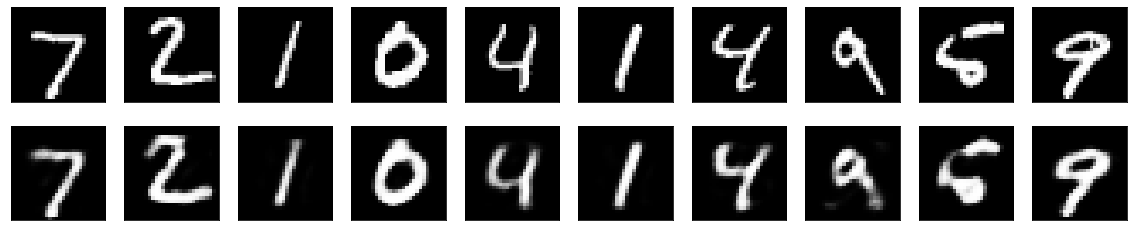

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
